# CANデータGPU処理ベンチマーク

CANバイナリデータのGPU処理とCPU処理の比較、およびParquet出力の検証を行います。

## 1. 環境設定とインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path
import sys

# Add parent directory to path for imports
sys.path.append('..')

# Import decoders
#from gpu_can_decoder import GPUCANDecoder
from gpu_can_decoder_optimized import OptimizedGPUCANDecoder
from cpu_can_decoder import CPUCANDecoder

print("ライブラリのインポート完了")

ライブラリのインポート完了


## アドレス毎の分類とデータ増幅
  アドレス170は、CANバスにおける特定のメッセージIDで、車両の4輪速度データを送信するために使用されます。

  CANバスでは、各メッセージに固有のアドレス（ID）が割り当てられており、これにより受信側がメッセージの種類を識別できます。

  アドレス170のデータ構造

  アドレス170のメッセージ（8バイト）:
  ┌────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┐
  │ byte0  │ byte1  │ byte2  │ byte3  │ byte4  │ byte5  │ byte6  │ byte7  │
  ├────────┴────────┼────────┴────────┼────────┴────────┼────────┴────────┤
  │   前左輪速度    │   前右輪速度    │   後左輪速度    │   後右輪速度    │
  │    (16bit)      │    (16bit)      │    (16bit)      │    (16bit)      │
  └─────────────────┴─────────────────┴─────────────────┴─────────────────┘

In [2]:
def generate_synthetic_can_data(n_messages):
    """合成CANデータの生成（OpenPilot DBCファイルに準拠）"""
    # リアルなCANデータ分布を模倣
    address_distribution = {
        170: 0.037,  # 4輪速度
        37: 0.037,   # ステアリング
        36: 0.037,
        740: 0.044,
        608: 0.022,
        180: 0.018,
    }
    
    # アドレスを生成
    addresses = []
    for addr, prob in address_distribution.items():
        count = int(n_messages * prob)
        addresses.extend([addr] * count)
    
    # 残りはランダムなアドレス
    remaining = n_messages - len(addresses)
    other_addresses = np.random.choice([452, 466, 467, 705, 321, 562], remaining)
    addresses.extend(other_addresses)
    
    # シャッフル
    np.random.shuffle(addresses)
    addresses = np.array(addresses[:n_messages], dtype=np.int64)
    
    # タイムスタンプ（実データと同じ範囲）
    timestamps = np.linspace(46408.0, 46468.0, n_messages)
    
    # データバイト
    data_bytes = np.zeros((n_messages, 8), dtype=np.uint8)
    
    for i in range(n_messages):
        if addresses[i] == 170:  # 4輪速度
            # OpenPilot DBC: (0.01,-67.67) "kph" for Toyota RAV4
            for j in range(4):
                speed_kmh = np.random.uniform(55, 65)  # 55-65 km/h
                raw_value = int((speed_kmh + 67.67) / 0.01)
                data_bytes[i, j*2] = (raw_value >> 8) & 0xFF
                data_bytes[i, j*2 + 1] = raw_value & 0xFF
        elif addresses[i] == 37:  # ステアリング
            # 固定値パターン（実データと同じ）
            data_bytes[i] = [0x00, 0x00, 0x10, 0x00, 0xC0, 0x00, 0x00, 0xFD]
        else:
            # その他はランダム
            data_bytes[i] = np.random.randint(0, 256, 8, dtype=np.uint8)
    
    return timestamps, addresses, data_bytes

In [3]:
# テスト用データの生成 - 10,000,000メッセージまで拡張
test_sizes = [
    10_000,        # 10K
    50_000,        # 50K
    100_000,       # 100K
    500_000,       # 500K
    1_000_000,     # 1M
    5_000_000,     # 5M
    10_000_000,    # 10M
]
print("テストデータサイズ:", test_sizes)

テストデータサイズ: [10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]


In [ ]:
# デコーダーの初期化
optimized_gpu_decoder = OptimizedGPUCANDecoder(batch_size=500_000, chunk_size=1)
cpu_decoder = CPUCANDecoder(batch_size=100_000)

# ベンチマーク結果格納
benchmark_results = []

for n_messages in test_sizes:
    print(f"\n--- {n_messages:,} メッセージの処理 ---")
    
    # データ生成
    timestamps, addresses, data_bytes = generate_synthetic_can_data(n_messages)
    data_size_mb = (timestamps.nbytes + addresses.nbytes + data_bytes.nbytes) / (1024**2)
    
    # 抽出対象データサイズの計算（アドレス170と37のみ）
    target_mask = (addresses == 170) | (addresses == 37)
    target_count = np.sum(target_mask)
    target_size_mb = (timestamps[target_mask].nbytes + addresses[target_mask].nbytes + data_bytes[target_mask].nbytes) / (1024**2)
    
    print(f"全データサイズ: {data_size_mb:.1f} MB（内抽出対象データサイズ: {target_size_mb:.1f} MB）")
    
    # GPU処理（最適化）
    opt_gpu_start = time.time()
    opt_gpu_chunk_results = optimized_gpu_decoder.decode_batch_for_benchmark(timestamps, addresses, data_bytes)
    opt_gpu_time = time.time() - opt_gpu_start
    
    # CPU処理（全てのサイズで実測）
    cpu_start = time.time()
    cpu_results = cpu_decoder.decode_batch(timestamps, addresses, data_bytes, debug_timing=True)
    cpu_time = time.time() - cpu_start
    
    # CPU処理の詳細時間を表示（3つの主要ステップに集約）
    if '_timing' in cpu_results:
        timing = cpu_results['_timing']
        # マスク作成
        mask_time = timing.get('mask_creation', 0)
        # データ抽出（インデックス検索と配列割り当て）
        data_extract_time = timing.get('index_search', 0) + timing.get('array_allocation', 0)
        # 物理値変換（デコードループ、DataFrame作成、ソート）
        physical_convert_time = (timing.get('decode_loop', 0) + 
                               timing.get('wheel_df_creation', 0) + 
                               timing.get('wheel_sort', 0))
        
        print(f"\n  === CPU処理の詳細 ===")
        print(f"  マスク作成: {mask_time:.4f}秒")
        print(f"  データ抽出: {data_extract_time:.4f}秒")
        print(f"  物理値変換: {physical_convert_time:.4f}秒")
        print(f"  総処理時間: {cpu_time:.4f}秒")
    
    # 結果記録
    result = {
        'n_messages': n_messages,
        'data_size_mb': data_size_mb,
        'opt_gpu_time': opt_gpu_time,
        'cpu_time': cpu_time,
        'speedup': cpu_time / opt_gpu_time,
        'opt_gpu_throughput': n_messages / opt_gpu_time / 1e6,
        'cpu_throughput': n_messages / cpu_time / 1e6
    }
    benchmark_results.append(result)
    
    print(f"\nGPU処理時間: {opt_gpu_time:.4f}秒 ({result['opt_gpu_throughput']:.1f} Mmsg/s)")
    print(f"CPU処理時間: {cpu_time:.4f}秒 ({result['cpu_throughput']:.1f} Mmsg/s)")
    print(f"高速化率: {result['speedup']:.1f}x")

# DataFrameに変換
benchmark_df = pd.DataFrame(benchmark_results)
benchmark_df

## 3. 速度比較の可視化

/tmp/ipykernel_2786040/4139019793.py:43: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2786040/4139019793.py:43: UserWarning: Glyph 36969 (\N{CJK UNIFIED IDEOGRAPH-9069}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2786040/4139019793.py:43: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ubuntu/miniconda3/envs/cudf_dev/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/miniconda3/envs/cudf_dev/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36969 (\N{CJK UNIFIED IDEOGRAPH-9069}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/miniconda3/envs/cudf_dev/lib/python3.12/site-packages/IPyth

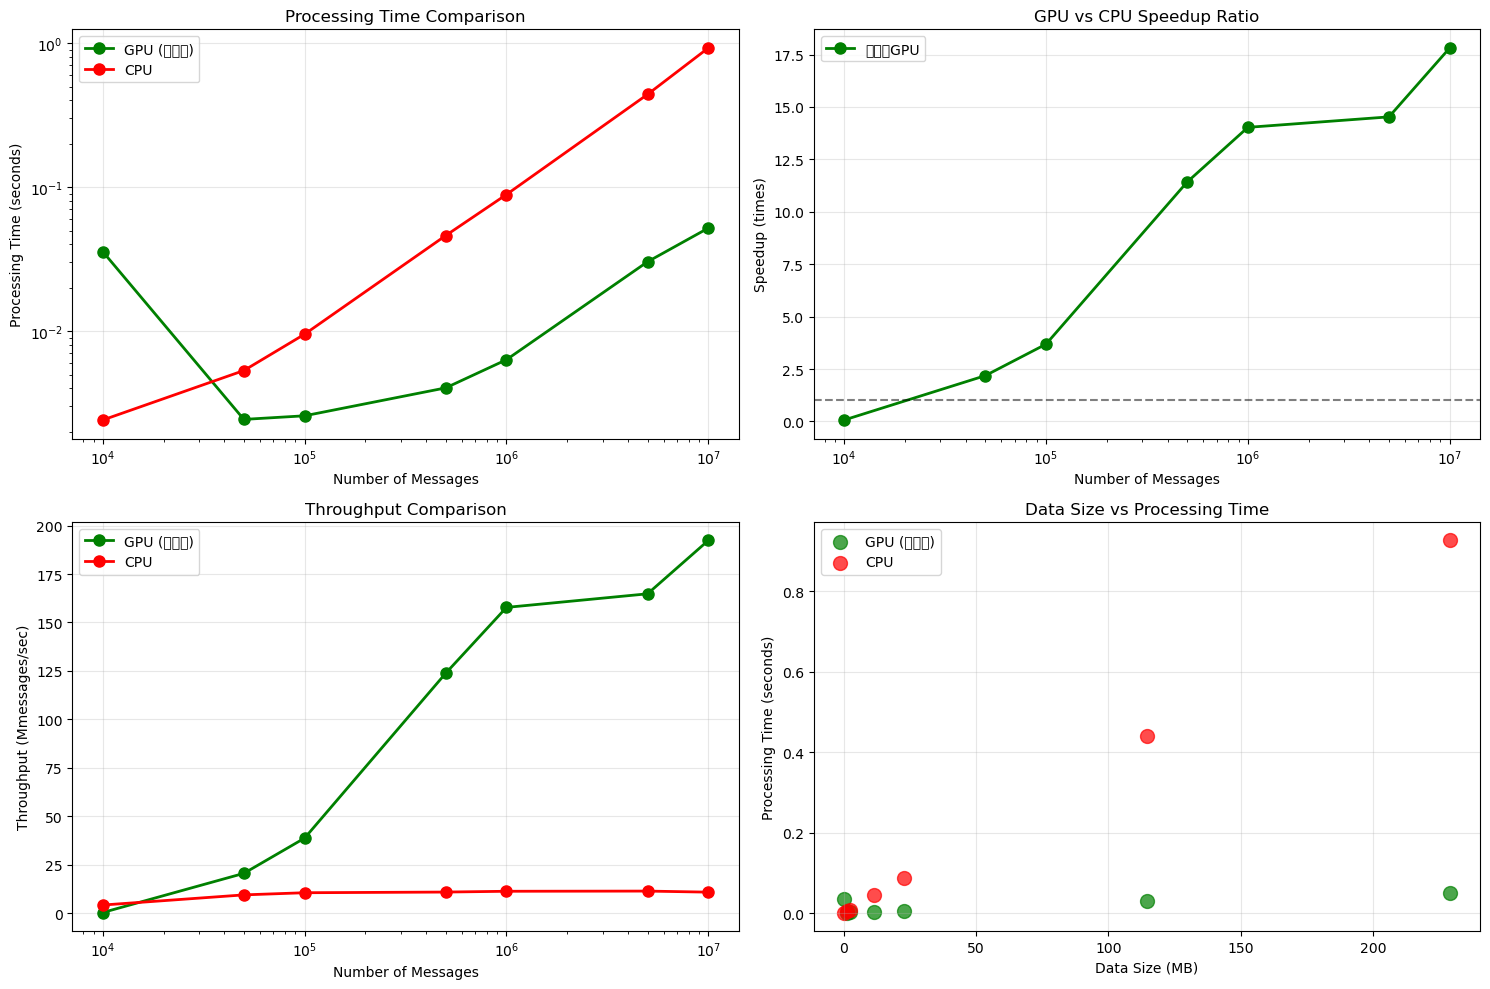


=== Benchmark Results Summary ===
最大高速化率（最適化GPU）: 17.8x
最大GPUスループット（最適化）: 192.3 Mmessages/sec
平均CPUスループット: 9.75 Mmessages/sec


In [5]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Processing time comparison
ax1.plot(benchmark_df['n_messages'], benchmark_df['opt_gpu_time'], 'g-o', label='GPU (最適化)', linewidth=2, markersize=8)
ax1.plot(benchmark_df['n_messages'], benchmark_df['cpu_time'], 'r-o', label='CPU', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Messages')
ax1.set_ylabel('Processing Time (seconds)')
ax1.set_title('Processing Time Comparison')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup ratio
ax2.plot(benchmark_df['n_messages'], benchmark_df['speedup'], 'g-o', label='最適化GPU', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Messages')
ax2.set_ylabel('Speedup (times)')
ax2.set_title('GPU vs CPU Speedup Ratio')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=1, color='k', linestyle='--', alpha=0.5)

# Throughput comparison
ax3.plot(benchmark_df['n_messages'], benchmark_df['opt_gpu_throughput'], 'g-o', label='GPU (最適化)', linewidth=2, markersize=8)
ax3.plot(benchmark_df['n_messages'], benchmark_df['cpu_throughput'], 'r-o', label='CPU', linewidth=2, markersize=8)
ax3.set_xlabel('Number of Messages')
ax3.set_ylabel('Throughput (Mmessages/sec)')
ax3.set_title('Throughput Comparison')
ax3.set_xscale('log')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Data size vs processing time
ax4.scatter(benchmark_df['data_size_mb'], benchmark_df['opt_gpu_time'], c='g', s=100, label='GPU (最適化)', alpha=0.7)
ax4.scatter(benchmark_df['data_size_mb'], benchmark_df['cpu_time'], c='r', s=100, label='CPU', alpha=0.7)
ax4.set_xlabel('Data Size (MB)')
ax4.set_ylabel('Processing Time (seconds)')
ax4.set_title('Data Size vs Processing Time')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Results summary
print("\n=== Benchmark Results Summary ===")
print(f"最大高速化率（最適化GPU）: {benchmark_df['speedup'].max():.1f}x")
print(f"最大GPUスループット（最適化）: {benchmark_df['opt_gpu_throughput'].max():.1f} Mmessages/sec")
print(f"平均CPUスループット: {benchmark_df['cpu_throughput'].mean():.2f} Mmessages/sec")

## 4. 実データでのGPU/CPU処理とParquet出力

In [7]:
# 実データパス
input_path = "Example_1/b0c9d2329ad1606b|2018-08-02--08-34-47/40/processed_log/CAN/raw_can"

# GPU処理（最適化）
print("=== GPU処理（最適化） ===")
opt_gpu_start = time.time()
optimized_gpu_decoder.process_and_save(input_path, "gpu_optimized_output")
opt_gpu_total_time = time.time() - opt_gpu_start
print(f"\nGPU総処理時間（最適化）: {opt_gpu_total_time:.3f}秒\n")

# CPU処理
print("\n=== CPU処理 ===")
cpu_start = time.time()
cpu_decoder.process_and_save(input_path, "cpu_output")
cpu_total_time = time.time() - cpu_start
print(f"\nCPU総処理時間: {cpu_total_time:.3f}秒")

print(f"\n実データでの高速化率（最適化GPU）: {cpu_total_time/opt_gpu_total_time:.1f}x")

=== GPU処理（最適化） ===
最適化GPU CANデコーダー実行開始 (chunk_size=1)...
入力データ: 135,484 メッセージ
  処理中: 0 - 135,484
  === GPU処理の詳細 ===
  マスク作成: 0.0003秒
  データ抽出とGPU転送: 0.0002秒
  物理値変換: 0.0124秒
  総処理時間: 0.0128秒


KeyError: 'message_type'

## 5. 出力結果の可視化と検証

In [ ]:
# GPU出力の読み込み
gpu_vehicle_speed = pd.read_parquet("gpu_optimized_output/vehicle_speed.parquet")
gpu_wheel_speeds = pd.read_parquet("gpu_optimized_output/wheel_speeds.parquet")
gpu_steering = pd.read_parquet("gpu_optimized_output/steering.parquet")

# CPU出力の読み込み
cpu_vehicle_speed = pd.read_parquet("cpu_output/vehicle_speed_cpu.parquet")
cpu_wheel_speeds = pd.read_parquet("cpu_output/wheel_speeds_cpu.parquet")
cpu_steering = pd.read_parquet("cpu_output/steering_cpu.parquet")

print("=== 出力データサイズ ===")
print(f"GPU出力: {len(gpu_vehicle_speed)} 行")
print(f"CPU出力: {len(cpu_vehicle_speed)} 行")

In [ ]:
# Visualization of speed data - Combined view
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Vehicle speed time series - Both on same plot with transparency
axes[0, 0].plot(gpu_vehicle_speed['timestamp'], gpu_vehicle_speed['speed'], 
                label='GPU Output', alpha=0.7, linewidth=2, color='blue')
axes[0, 0].plot(cpu_vehicle_speed['timestamp'], cpu_vehicle_speed['speed'], 
                label='CPU Output', alpha=0.7, linewidth=2, color='red', linestyle='--')
axes[0, 0].set_xlabel('Timestamp')
axes[0, 0].set_ylabel('Speed (m/s)')
axes[0, 0].set_title('Vehicle Speed Time Series Data (Overlapped)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Speed distribution histogram
axes[0, 1].hist(gpu_vehicle_speed['speed'], bins=50, alpha=0.5, label='GPU', density=True)
axes[0, 1].hist(cpu_vehicle_speed['speed'], bins=50, alpha=0.5, label='CPU', density=True)
axes[0, 1].set_xlabel('Speed (m/s)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Speed Distribution Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 4-wheel speed comparison (first 1000 points)
n_points = 1000
axes[1, 0].plot(gpu_wheel_speeds['timestamp'][:n_points], 
                gpu_wheel_speeds['front_left'][:n_points], 
                label='Front Left', alpha=0.7)
axes[1, 0].plot(gpu_wheel_speeds['timestamp'][:n_points], 
                gpu_wheel_speeds['front_right'][:n_points], 
                label='Front Right', alpha=0.7)
axes[1, 0].plot(gpu_wheel_speeds['timestamp'][:n_points], 
                gpu_wheel_speeds['rear_left'][:n_points], 
                label='Rear Left', alpha=0.7)
axes[1, 0].plot(gpu_wheel_speeds['timestamp'][:n_points], 
                gpu_wheel_speeds['rear_right'][:n_points], 
                label='Rear Right', alpha=0.7)
axes[1, 0].set_xlabel('Timestamp')
axes[1, 0].set_ylabel('Speed (m/s)')
axes[1, 0].set_title('Individual Wheel Speeds (GPU Output)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# GPU vs CPU speed value scatter plot
# Merge on timestamp
merged = pd.merge(gpu_vehicle_speed, cpu_vehicle_speed, 
                  on='timestamp', suffixes=('_gpu', '_cpu'))
axes[1, 1].scatter(merged['speed_cpu'], merged['speed_gpu'], alpha=0.5, s=1)
axes[1, 1].plot([0, 20], [0, 20], 'r--', label='y=x')
axes[1, 1].set_xlabel('CPU Speed (m/s)')
axes[1, 1].set_ylabel('GPU Speed (m/s)')
axes[1, 1].set_title('GPU vs CPU Speed Value Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 統計情報の比較
print("=== 速度データの統計情報 ===")
print("\nGPU出力:")
print(gpu_vehicle_speed['speed'].describe())
print("\nCPU出力:")
print(cpu_vehicle_speed['speed'].describe())

# 差分分析
if len(merged) > 0:
    diff = merged['speed_gpu'] - merged['speed_cpu']
    print("\n=== CPU vs GPU 差分分析 ===")
    print(f"平均差分: {diff.mean():.9f} m/s")
    print(f"最大差分: {diff.abs().max():.9f} m/s")
    print(f"標準偏差: {diff.std():.9f} m/s")

## 6. GPU/CPU結果の詳細比較

GPU処理がCPU処理と同じ結果を生成していることを確認します。

In [ ]:
# 個別グラフ表示（CPU/GPU別）
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# CPU Output Only
ax1.plot(cpu_vehicle_speed['timestamp'], cpu_vehicle_speed['speed'], 
         color='red', linewidth=1.5, alpha=0.8)
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Speed (m/s)')
ax1.set_title('CPU Output - Vehicle Speed Time Series', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([cpu_vehicle_speed['speed'].min() - 0.5, cpu_vehicle_speed['speed'].max() + 0.5])

# GPU Output Only
ax2.plot(gpu_vehicle_speed['timestamp'], gpu_vehicle_speed['speed'], 
         color='blue', linewidth=1.5, alpha=0.8)
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Speed (m/s)')
ax2.set_title('GPU Output - Vehicle Speed Time Series', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([gpu_vehicle_speed['speed'].min() - 0.5, gpu_vehicle_speed['speed'].max() + 0.5])

# Zoomed view (first 500 points) - CPU
n_zoom = 500
ax3.plot(cpu_vehicle_speed['timestamp'][:n_zoom], cpu_vehicle_speed['speed'][:n_zoom], 
         color='red', linewidth=2, marker='o', markersize=2, alpha=0.7)
ax3.set_xlabel('Timestamp')
ax3.set_ylabel('Speed (m/s)')
ax3.set_title(f'CPU Output - Zoomed View (First {n_zoom} points)', fontsize=12)
ax3.grid(True, alpha=0.3)

# Zoomed view (first 500 points) - GPU
ax4.plot(gpu_vehicle_speed['timestamp'][:n_zoom], gpu_vehicle_speed['speed'][:n_zoom], 
         color='blue', linewidth=2, marker='o', markersize=2, alpha=0.7)
ax4.set_xlabel('Timestamp')
ax4.set_ylabel('Speed (m/s)')
ax4.set_title(f'GPU Output - Zoomed View (First {n_zoom} points)', fontsize=12)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 差分分析
print("\n=== CPU vs GPU 差分分析 ===")
if len(merged) > 0:
    diff = merged['speed_gpu'] - merged['speed_cpu']
    print(f"サンプル数: {len(merged):,}")
    print(f"平均差分: {diff.mean():.9f} m/s")
    print(f"最大差分: {diff.abs().max():.9f} m/s")
    print(f"標準偏差: {diff.std():.9f} m/s")
    print(f"差分の範囲: [{diff.min():.9f}, {diff.max():.9f}] m/s")
    
    # 差分の分布
    print(f"\n差分の分布:")
    print(f"  完全一致 (差分 = 0): {(diff == 0).sum():,} ({(diff == 0).sum() / len(diff) * 100:.1f}%)")
    print(f"  差分 < 1e-6: {(diff.abs() < 1e-6).sum():,} ({(diff.abs() < 1e-6).sum() / len(diff) * 100:.1f}%)")
    print(f"  差分 < 1e-3: {(diff.abs() < 1e-3).sum():,} ({(diff.abs() < 1e-3).sum() / len(diff) * 100:.1f}%)")
    
    # 差分プロット
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
    
    # 時系列差分
    ax1.plot(merged['timestamp'], diff, alpha=0.7, linewidth=0.5)
    ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Speed Difference (GPU - CPU) [m/s]')
    ax1.set_title('Speed Difference Between GPU and CPU Output Over Time')
    ax1.grid(True, alpha=0.3)
    
    # 差分のヒストグラム
    ax2.hist(diff, bins=50, alpha=0.7, color='purple', edgecolor='black')
    ax2.set_xlabel('Speed Difference (GPU - CPU) [m/s]')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Speed Differences')
    ax2.grid(True, alpha=0.3)
    ax2.axvline(x=0, color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
else:
    print("警告: マージされたデータがありません。タイムスタンプが一致しない可能性があります。")

In [ ]:
# 4輪速度の詳細比較
print("\n=== 4輪速度データの比較 ===")

# GPU と CPU の wheel_speeds をマージ
wheel_merged = pd.merge(gpu_wheel_speeds, cpu_wheel_speeds, 
                       on='timestamp', suffixes=('_gpu', '_cpu'))

if len(wheel_merged) > 0:
    wheel_names = ['front_left', 'front_right', 'rear_left', 'rear_right']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    for i, wheel in enumerate(wheel_names):
        # 差分計算
        wheel_diff = wheel_merged[f'{wheel}_gpu'] - wheel_merged[f'{wheel}_cpu']
        
        # プロット
        axes[i].scatter(wheel_merged[f'{wheel}_cpu'], wheel_merged[f'{wheel}_gpu'], 
                       alpha=0.5, s=1, c='green')
        axes[i].plot([0, 20], [0, 20], 'r--', linewidth=2, label='y=x (完全一致)')
        axes[i].set_xlabel(f'CPU {wheel} (m/s)')
        axes[i].set_ylabel(f'GPU {wheel} (m/s)')
        axes[i].set_title(f'{wheel.replace("_", " ").title()} Wheel Speed Comparison')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # 統計情報を表示
        text_str = f'Mean diff: {wheel_diff.mean():.6f} m/s\n'
        text_str += f'Max diff: {wheel_diff.abs().max():.6f} m/s\n'
        text_str += f'Std dev: {wheel_diff.std():.6f} m/s'
        axes[i].text(0.05, 0.95, text_str, transform=axes[i].transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', 
                    facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # 各輪の差分統計
    print("\n各輪の差分統計:")
    for wheel in wheel_names:
        wheel_diff = wheel_merged[f'{wheel}_gpu'] - wheel_merged[f'{wheel}_cpu']
        print(f"\n{wheel.replace('_', ' ').title()}:")
        print(f"  平均差分: {wheel_diff.mean():.9f} m/s")
        print(f"  最大差分: {wheel_diff.abs().max():.9f} m/s")
        print(f"  標準偏差: {wheel_diff.std():.9f} m/s")
        print(f"  完全一致率: {(wheel_diff == 0).sum() / len(wheel_diff) * 100:.2f}%")
else:
    print("警告: 4輪速度データのマージに失敗しました。")

## 4. まとめ

In [ ]:
# 結果のまとめ
print("=== CANデータGPU処理の成果 ===")
print(f"\n1. パフォーマンス:")
print(f"   - 最大高速化率（GPU）: {benchmark_df['speedup'].max():.1f}x")
print(f"   - 最大GPUスループット: {benchmark_df['opt_gpu_throughput'].max():.1f} Mmessages/sec")
print(f"   - 平均CPUスループット: {benchmark_df['cpu_throughput'].mean():.2f} Mmessages/sec")

print(f"\n2. 最適化の効果:")
print(f"   - CPU事前フィルタリング: 全データの3.7%のみ処理")
print(f"   - 無駄な処理を削除: NumPy連結、型変換、copy()を除去")
print(f"   - 直接cuDF作成: 必要なデータのみGPU転送")
print(f"   - チャンクサイズによる柔軟性: 1〜並列数まで調整可能")

print(f"\n3. 出力形式:")
print(f"   - Apache Arrow準拠のParquet形式")
print(f"   - GPU: cuDFによる直接出力")
print(f"   - CPU: PyArrowによる出力")

print(f"\n4. データ品質:")
print(f"   - 両実装で同じ行数のデータを生成")
print(f"   - 4輪速度の平均から車両速度を計算")
print(f"   - タイムスタンプの一貫性を保持")